In [8]:
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from train import create_net
from utils import transforms as MT
from utils.datasets import AortaDataset3DCenter

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
n_channels, n_classes, batch_size = 1, 4, 128

transform = T.Compose([
    MT.Resize3D(81),
    MT.CenterCrop3D(81),
    MT.ToTensor3D(),
])

train = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/train/', transform=transform, depth=7)
val = AortaDataset3DCenter('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/center/val/', transform=transform, depth=7)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

[INFO]: Creating dataset with 61609 examples. Depth:7, Step:1, Residual:False
[INFO]: Creating dataset with 13503 examples. Depth:7, Step:1, Residual:False


In [ ]:
n_channels, n_classes, batch_size = 1, 4, 128

transform = T.Compose([
    T.Resize(81), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(81), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
])

train = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/', transform=transform, loader=lambda path: Image.open(path))
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [4]:
net = create_net(device, 'resnet', 34, n_channels, n_classes, '/nfs3-p2/zsxm/temp_path/3d81.pth', entire=True, flag_3d=True)
net.eval()
print('')

[INFO]: **********************************************************************
Network: ResNet3D_34
	1 input channels
	4 output channels (classes)
	3D model: True

[INFO]: Model loaded from /nfs3-p2/zsxm/temp_path/3d81.pth



In [19]:
class HookModule:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        print(grads[0].shape)
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
hook = HookModule(net, net.encoder.layer4[2].conv1)

In [18]:
hook.remove()

In [20]:
def get_grads(dataset, dataloader, end=500, start=0):
    idx = 0
    score_list = [[] for _ in range(n_classes)]
    err_list = [[] for _ in range(n_classes)]
    for imgs, true_categories in tqdm(dataloader, total=len(dataloader), desc='Dataset', unit='batch', leave=False):
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_categories = true_categories.to(device=device, dtype=torch.long)

        with torch.no_grad():
            categories_pred = torch.softmax(net(imgs), dim=1)
            labels_pred = categories_pred.argmax(dim=1)
            for i in range(len(true_categories)):
                if labels_pred[i] == true_categories[i]:
                    score_list[true_categories[i].item()].append((categories_pred[i, labels_pred[i]].item(), idx))
                else:
                    #err_list[true_categories[i].item()].append(dataset.samples[idx][0])
                    pass
                idx += 1
    
    grad_list = []
    mask_list = []
    for i in range(n_classes):
        print(len(score_list[i]))
        score_list[i].sort(key=lambda x: x[0], reverse=True)
        print(score_list[i][end-1])
        idx_list = [score[1] for score in score_list[i][start: end]]
        tensor_list = []
        for idx in idx_list:
            tensor_list.append(dataset[idx][0])
        batch = torch.stack(tensor_list, dim=0)
        pred = net(batch.to(device))
        nll_loss = F.nll_loss(pred, (torch.ones(batch.size(0))*i).to(device, dtype=torch.long))
        grads = hook.grads(-nll_loss, True, False)
        nll_loss.backward()
        grads = grads.abs().sum(dim=(2,3,4)).mean(dim=0)
        print(grads.shape)
        grad_list.append(grads.cpu().numpy())
        mask = (grads>grads.mean()).long()
        mask_list.append(mask.cpu().numpy())

    grads = np.array(grad_list)
    masks = np.array(mask_list)
    return grads, masks, err_list

In [21]:
grads, masks, err_list = get_grads(train, train_loader, 500)

31994
(1.0, 641)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])
21171
(1.0, 34636)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])
4846
(1.0, 54937)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])
3446
(1.0, 60288)
torch.Size([500, 512, 1, 3, 3])
torch.Size([512])


In [ ]:
# for i in range(n_classes):
#     print(len(err_list[i]))
#     outpath = os.path.join('/nfs3-p2/zsxm/dataset/aorta_classify_ct_-100_500/err_imgs', str(i))
#     os.makedirs(outpath, exist_ok=True)
#     for img in err_list[i]:
#         shutil.copy(img, os.path.join(outpath, img.split('/')[-1]))

[[          0     0.02327           0 ...    0.017705    0.011608   0.0088901]
 [          0     0.01317           0 ...    0.020179    0.013465    0.043075]
 [          0    0.026653           0 ...    0.014409    0.018537    0.039825]
 [          0    0.025083           0 ...   0.0093521    0.015629    0.060162]]


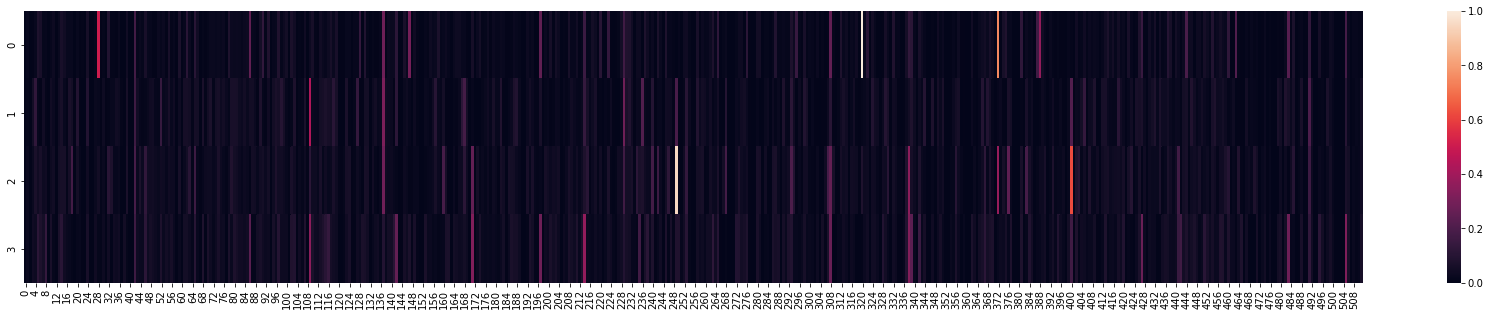

In [22]:
hm = grads - np.min(grads)
hm = hm / np.max(hm)
print(hm)

def view_grads(grads, fig_w, fig_h, fig_path='./heatmap.png'):
    f, ax = plt.subplots(figsize=(fig_w, fig_h), ncols=1)
    ax.set_xlabel('convolutional kernel')
    ax.set_ylabel('category')
    sns.heatmap(grads, annot=False, ax=ax)
    plt.savefig(fig_path, bbox_inches='tight')
    plt.show()
    #plt.clf()
    
view_grads(hm, 30, 5)

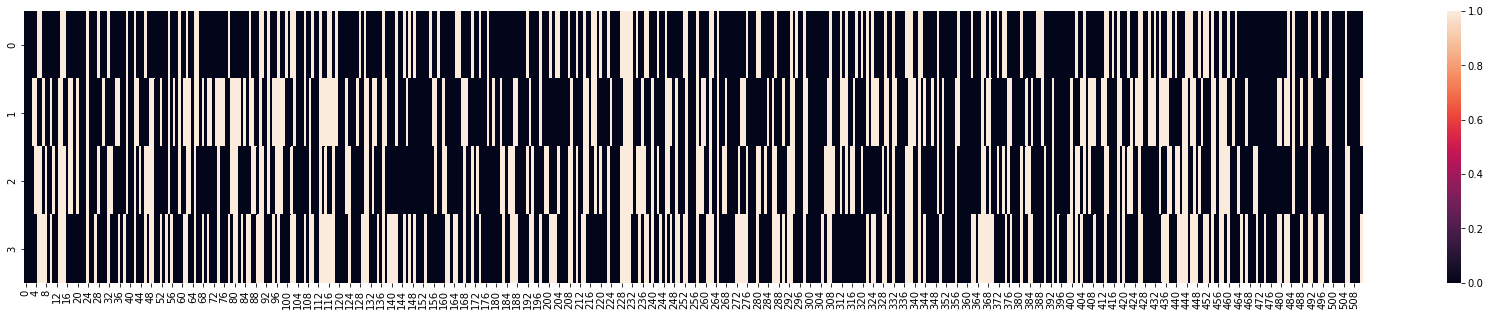

In [23]:
view_grads(masks, 30, 5)

In [24]:
np.save('/nfs3-p2/zsxm/temp_path/3dconv1.npy', masks)

In [2]:
a = (1,2,3)
x, y, z = a
print(x, y, z)

1 2 3


In [ ]:
class AdNoise:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
        outputs += torch.randn(outputs.shape).to(outputs.device)
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
class Mul2:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
        outputs *= 2
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()

In [ ]:
class Test(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 1, 3)
        nn.init.constant_(self.conv1.weight, 1)
        nn.init.constant_(self.conv1.weight, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.exp(x)
        x = self.conv2(x)
        return x
    
test = Test()

In [ ]:
h2 = Mul2(test, test.conv1)

In [ ]:
h2.remove()

In [ ]:
hn = AdNoise(test, test.conv1)

In [ ]:
hn.remove()

In [ ]:
a = torch.ones(2,3,6,6)
res = test(a)
ressum = res.sum()
print(res)
print(ressum)

In [ ]:
print(h2.outputs)
print(h2.grads(ressum))

In [ ]:
print(h2.outputs)
print(h2.grads(ressum))

In [ ]:
print(hn.outputs)
print(hn.grads(ressum))

In [ ]:
t = torch.ones(2,2)
print(id(t))

In [ ]:
t += 1
print(id(t))

In [ ]:
t = t+1
print(id(t))

In [ ]:
a = 1
b = a
print(id(a), id(b))

In [ ]:
def bad_append(new_item, a_list=[]):
 
    a_list.append(new_item)
 
    return a_list

In [ ]:
print(bad_append(1))

In [ ]:
a = (1,2)
a[0] = 3

In [ ]:
class Test():
    a = None
    
def fun(x):
    x = Test()
    x.a = 7

In [ ]:
t, k = Test(), Test()
t.a = 1
k.a = 2
p = t
print(p.a, t.a, k.a)
print(id(p), id(t), id(k))
p = k
print(p.a, t.a, k.a)
print(id(p), id(t), id(k))